# Synthetic Discussions analysis

## Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import re
import shutil

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tasks.graphs import save_plot
import tasks.stats
import tasks.postprocessing

tqdm.tqdm.pandas()

In [2]:
MODERATION_STRATEGY_MAP = {
    "vanilla": "No Instructions",
    "moderation_game": "Moderation Game",
    "no_moderator": "No Moderator",
    "erulemaking": "Human Mod. Guidelines",
    "constructive_communications": "Human Fac. Guidelines",
    "collective_constitution": "Rules Only"
}

MODEL_MAP = {
    "hardcoded": "hardcoded",
    "mistral-nemo-abliterated": "Mistral Nemo (abl.)",
    "qwen2.5-32b-4bit": "Qwen 2.5",
    "llama-3.1-70b-4bit": "LLaMa 3.1"
}

In [ ]:
shutil.unpack_archive("../data/dataset.zip", "../data")
full_df = pd.read_csv("../data/dataset.csv", encoding="utf8")

full_df.conv_variant = full_df.conv_variant.map(MODERATION_STRATEGY_MAP)
full_df.model = full_df.model.map(MODEL_MAP)
full_df = tasks.postprocessing.format_dataset(full_df, min_message_len=3)
full_df = full_df.rename({"argumentquality": "Argument Quality"}, axis=1)
full_df

In [5]:
df = full_df[~full_df.not_intervened]
df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,toxicity,Argument Quality,polarization,not_intervened
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,3,0.833333,False
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,0.833333,False
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,0.833333,False
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,0.833333,False
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,2,0.833333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57316,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,0.000000,False
57317,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,0.000000,False
57318,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,0.000000,False
57319,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,0.000000,False


## Analysis

### User intent impact on toxicity

In [6]:
METRICS = ["toxicity", "Argument Quality", "polarization"]
GRAPH_OUTPUT_DIR = Path("../graphs")
TOXICITY_TICKS = np.arange(1, 6, 1)
POLARIZATION_TICKS = np.arange(0, 1.2, 0.2)

sns.set(style="whitegrid")


def plot_metrics_barplots(df: pd.DataFrame, group_by_col: str, group_by_col_label: str) -> None:
    fig, axes = plt.subplots(1, len(METRICS))
    fig.set_size_inches(12, 6)

    for ax, metric in zip(axes, METRICS):

        sns.barplot(
            data=df,
            x=group_by_col,
            hue=group_by_col,
            y=metric,
            errorbar="sd",
            legend=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90, labelsize=8)
        ax.set_xlabel("")
        ax.set_ylabel(metric.capitalize())
        if metric == "toxicity" or metric == "Argument Quality":
            ax.set_yticks(TOXICITY_TICKS)
        else:
            ax.set_yticks(POLARIZATION_TICKS)

    fig.suptitle(f"Impact of {group_by_col_label} on Discussions")
    fig.supxlabel(group_by_col_label)
    fig.supylabel("Annotation Scores")
    fig.tight_layout()

In [7]:
no_hardocoded_df = full_df[full_df.model !="hardcoded"]

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


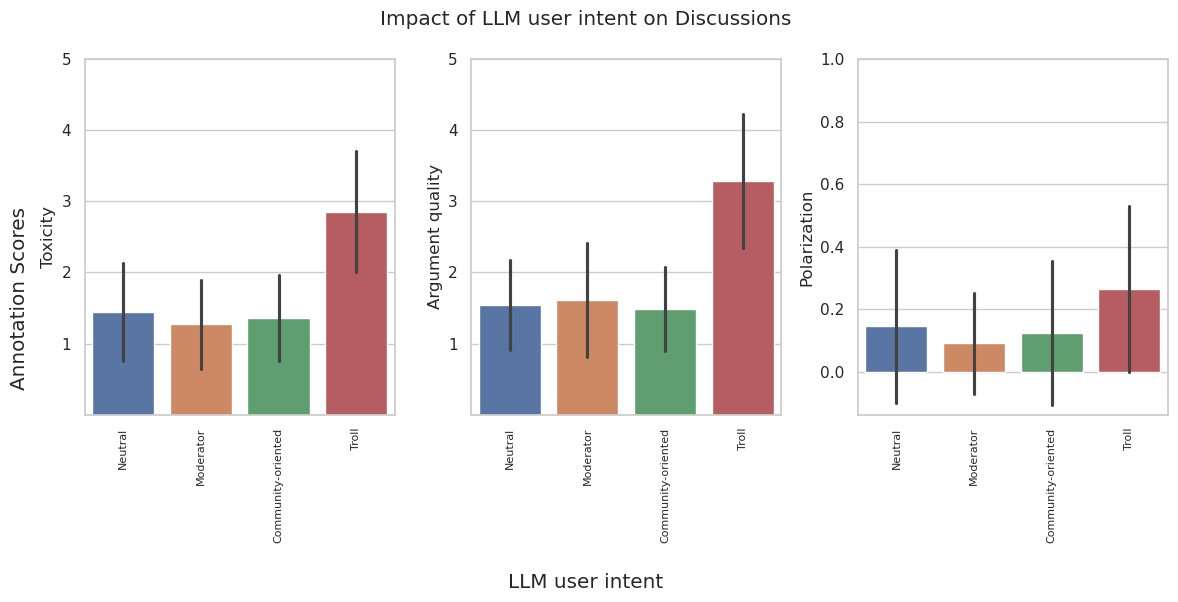

In [8]:
plot_metrics_barplots(no_hardocoded_df, "intent", "LLM user intent")
save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


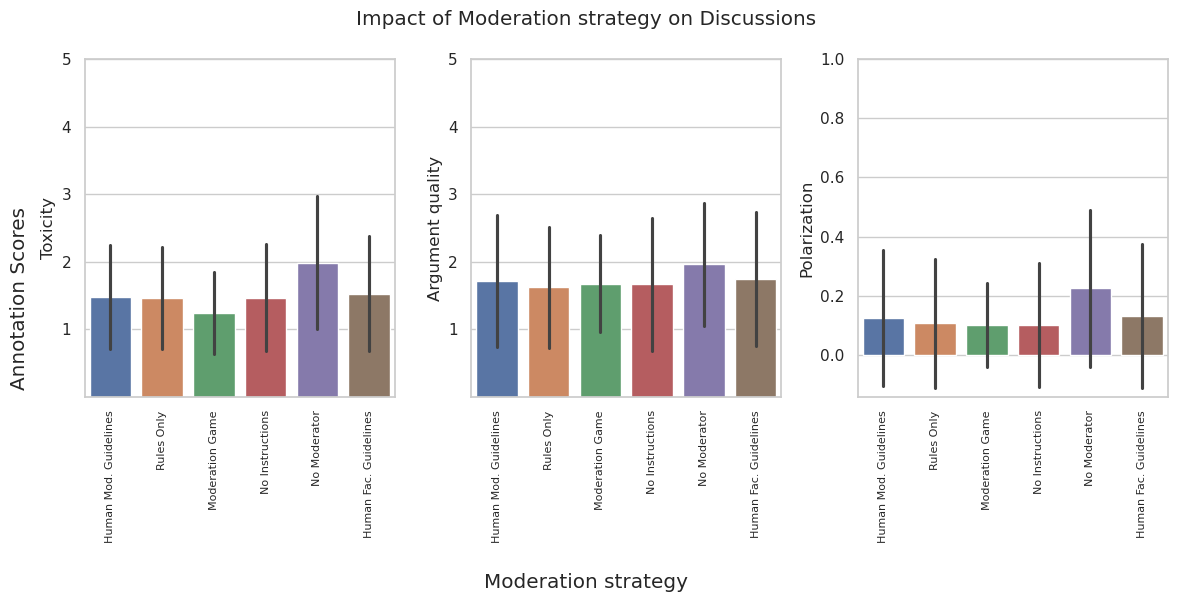

In [9]:
plot_metrics_barplots(no_hardocoded_df, "conv_variant", "Moderation strategy")
save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

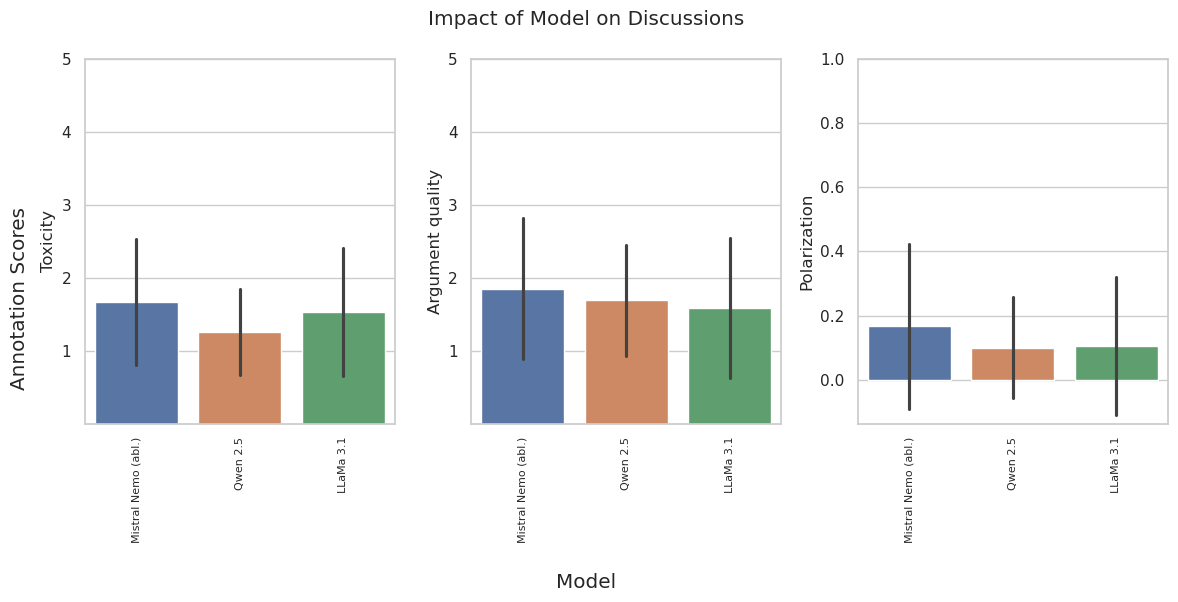

In [10]:
plot_metrics_barplots(no_hardocoded_df, "model", "Model")
plt.show()

### Moderator impact

In [11]:
no_mod_df = df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = no_mod_df[contains_mod].message_order // 2  + 1

In [12]:
def plot_timeseries(df: pd.DataFrame, y_col: str, hue_col: str, hue_col_label: str) -> None:
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=no_mod_df,
        x="message_order",
        y=y_col,
        hue=hue_col,
        lw=1,
        alpha=0.6,
    )

    plt.title(f"Average (all comments from all annotators) {y_col.capitalize()} by {hue_col_label}")
    plt.xlabel("Discussion Length (# messages)")
    plt.ylabel(f"Average {y_col.capitalize()}")
    plt.xticks(rotation=45)

    plt.legend(title=hue_col_label)
    plt.tight_layout()

### Intent Impact

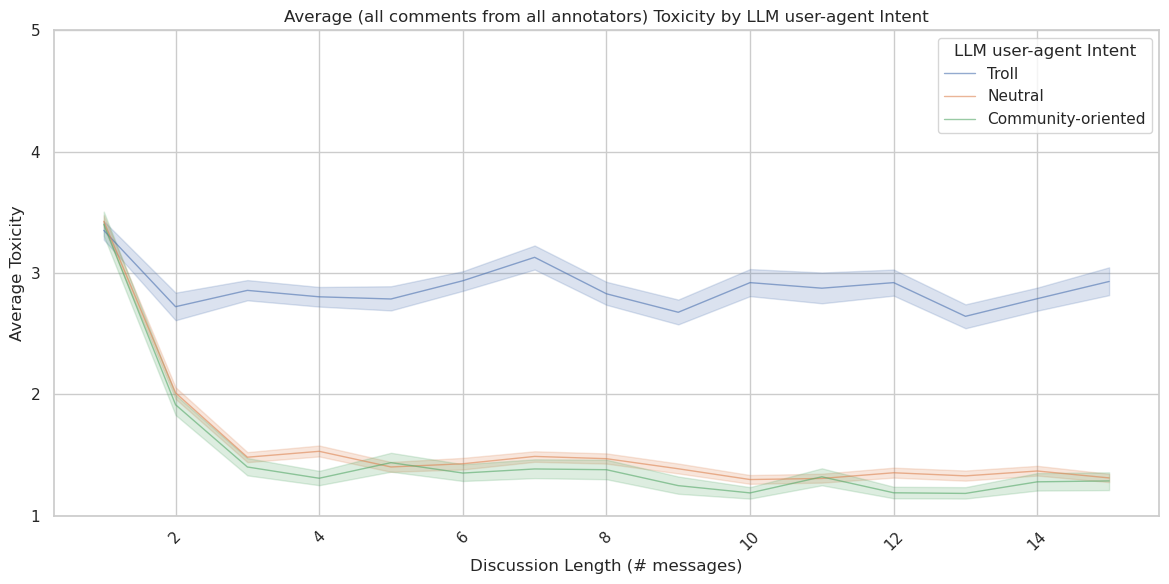

In [13]:
plot_timeseries(no_mod_df, y_col="toxicity", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)
plt.show()

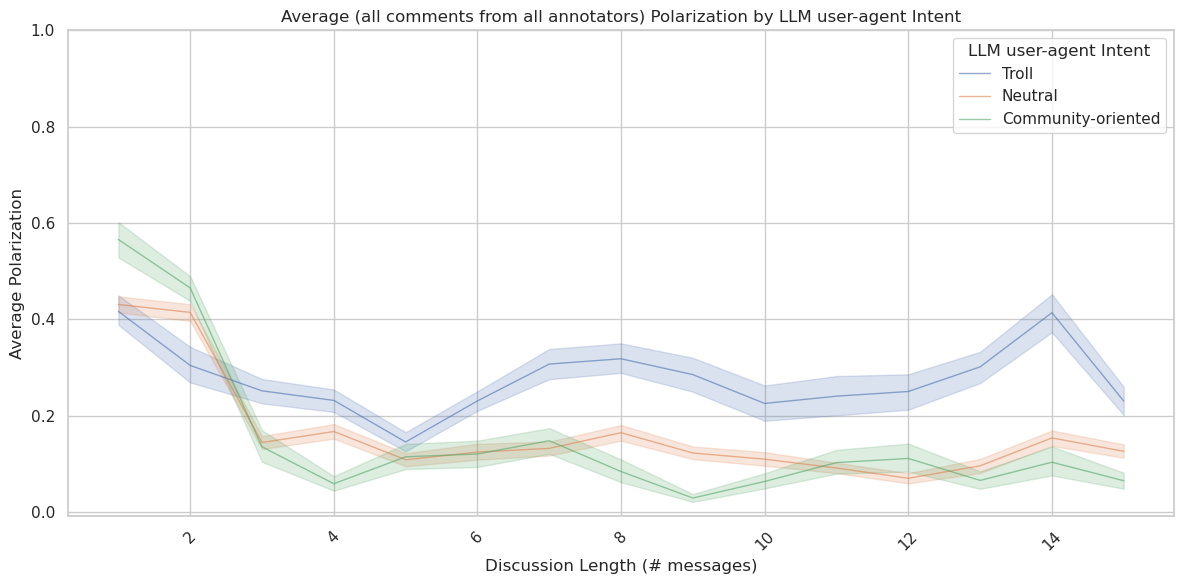

In [14]:
plot_timeseries(no_mod_df, y_col="polarization", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(POLARIZATION_TICKS)
plt.show()

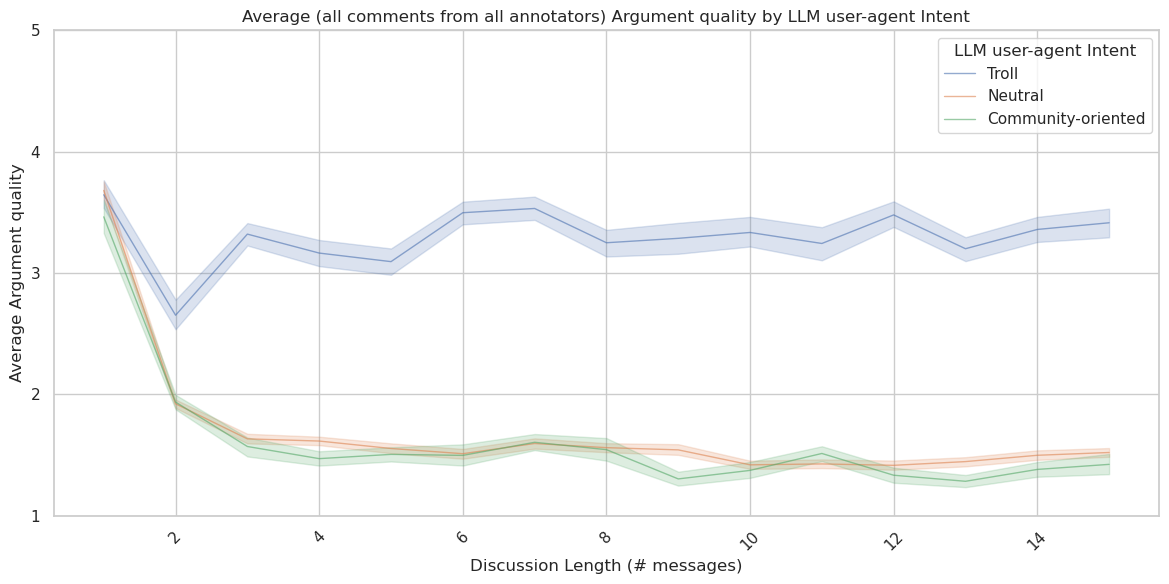

In [15]:
plot_timeseries(no_mod_df, y_col="Argument Quality", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderation Strategy Impact

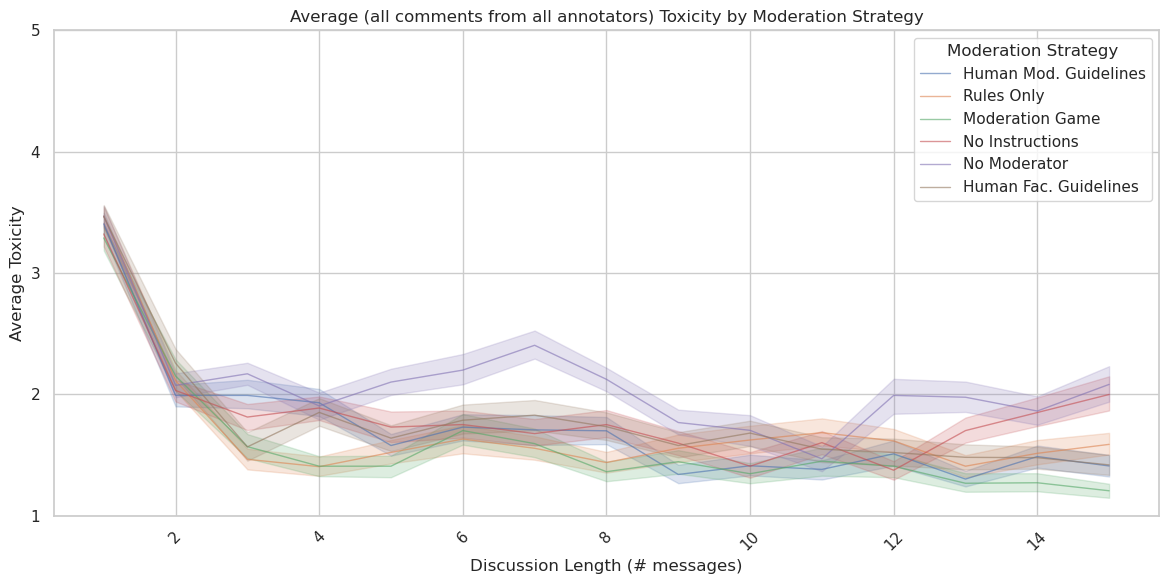

In [16]:
plot_timeseries(no_mod_df, y_col="toxicity", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(TOXICITY_TICKS)
plt.show()

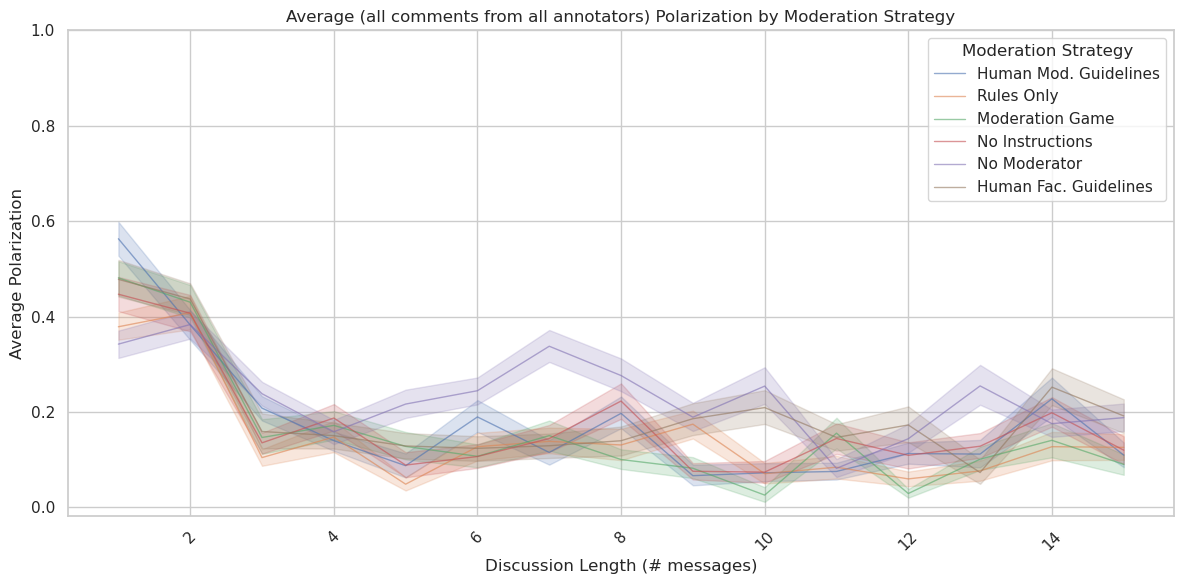

In [17]:
plot_timeseries(no_mod_df, y_col="polarization", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(POLARIZATION_TICKS)
plt.show()

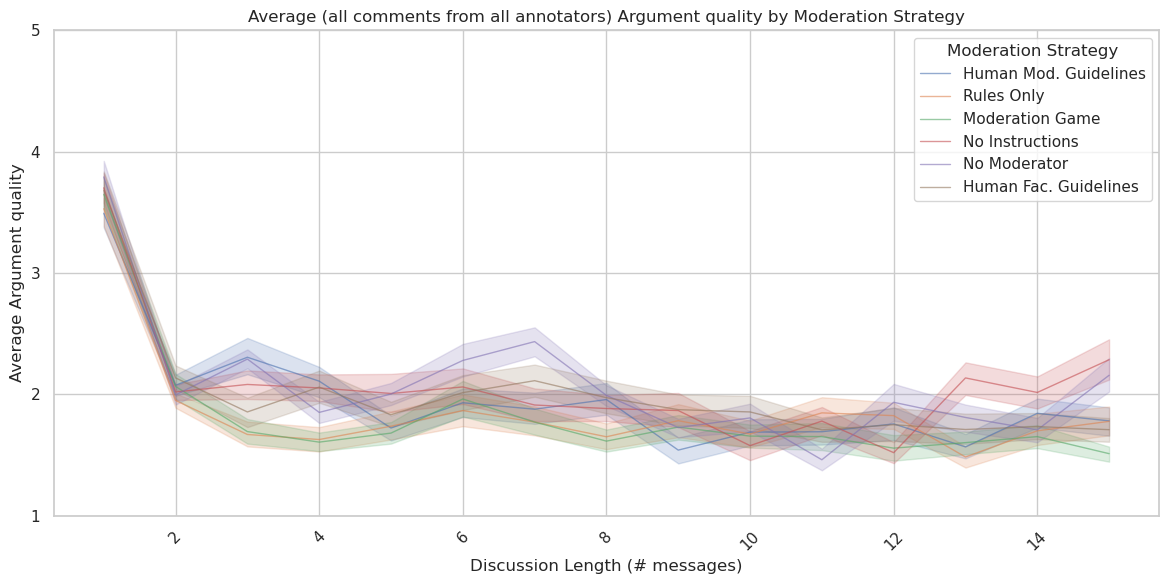

In [18]:
plot_timeseries(no_mod_df, y_col="Argument Quality", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderator Interventions

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


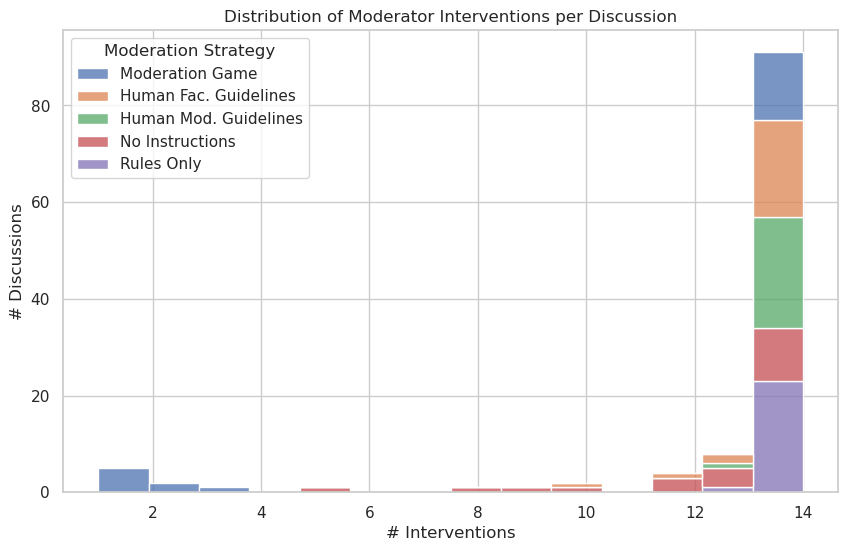

In [19]:
df_unique = df[df["conv_variant"] != "no_moderator"].drop_duplicates(
    subset=["message_id"]
)

# Compute number of moderator interventions per conversation
moderator_interventions = df_unique[df_unique["is_moderator"]].groupby("conv_id").size()

# Merge with conversation variants
conv_variants = (
    df_unique[["conv_id", "conv_variant"]].drop_duplicates().set_index("conv_id")
)
moderator_interventions = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=moderator_interventions.rename({"conv_variant": "Moderation Strategy"}, axis=1),
    x="moderator_interventions",
    hue="Moderation Strategy",
    multiple="stack",
    bins=14,
)
plt.xlabel("# Interventions")
plt.ylabel("# Discussions")
plt.title("Distribution of Moderator Interventions per Discussion")

save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

### Annotators

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/polarization_toxicity.png


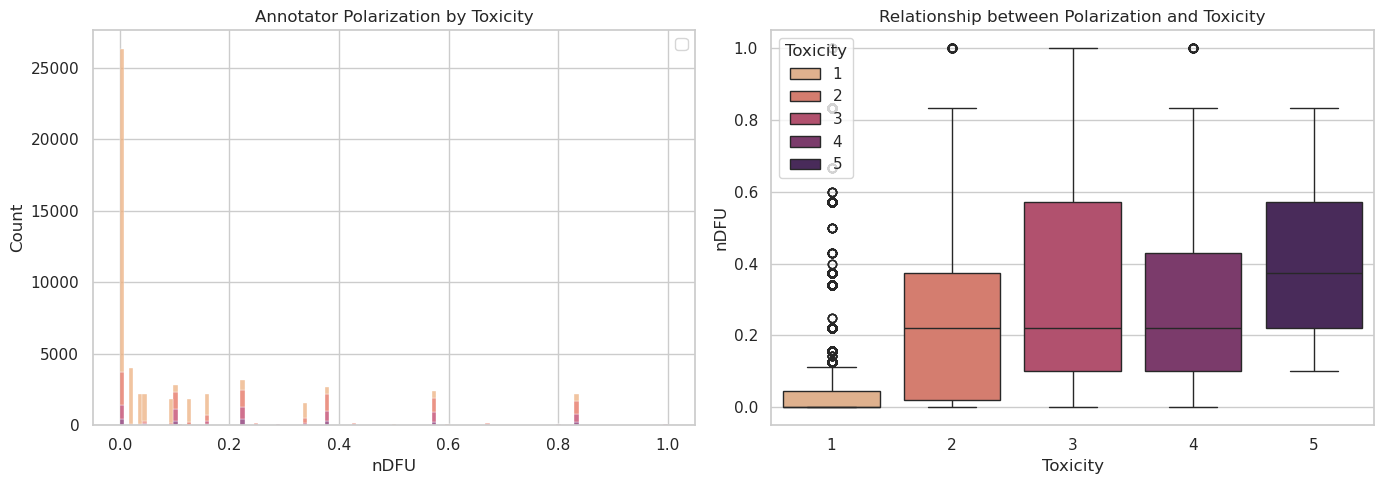

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df, x="polarization", hue="toxicity", palette="flare", multiple="stack", ax=axes[0])
axes[0].set_title("Annotator Polarization by Toxicity")
axes[0].set_xlabel("nDFU")
axes[0].legend("")

sns.boxplot(df, y="polarization", x="toxicity", hue="toxicity", palette="flare", ax=axes[1])
axes[1].set_title("Relationship between Polarization and Toxicity")
axes[1].set_xlabel("Toxicity")
axes[1].set_ylabel("nDFU")
axes[1].legend(title="Toxicity", loc="upper left")

plt.tight_layout()

save_plot(GRAPH_OUTPUT_DIR / "polarization_toxicity.png")
plt.show()


## Investigating the rise of vanilla annotations

In [21]:
def intent_ratio(sus_df, other_df):
    other_value_counts = other_df.intent.value_counts()
    other_ratio = other_value_counts["Troll"] / other_value_counts.sum() * 100

    sus_value_counts = sus_df.intent.value_counts()
    sus_ratio = sus_value_counts["Troll"] / sus_value_counts.sum() * 100

    print(f"Suspicious area troll/other ratio: {sus_ratio:.2f}%")
    print(f"Other area troll/other ratio: {other_ratio:.2f}%")


Explain vanilla bump:

In [22]:
vanilla_df = df[df.conv_variant=="No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 28) & (vanilla_df.message_order >= 23)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 13.24%
Other area troll/other ratio: 8.78%


Explain moderation game bump:

In [23]:
mod_game_df = df[df.conv_variant=="Moderation Game"]
sus_df = mod_game_df[(mod_game_df.message_order <= 22) & (mod_game_df.message_order >= 19)]
other_df = mod_game_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 1.75%
Other area troll/other ratio: 1.98%


Baseline: ratios on stable area

In [24]:
vanilla_df = df[df.conv_variant=="No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 22) & (vanilla_df.message_order >= 19)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 2.91%
Other area troll/other ratio: 8.78%


## Impact of models

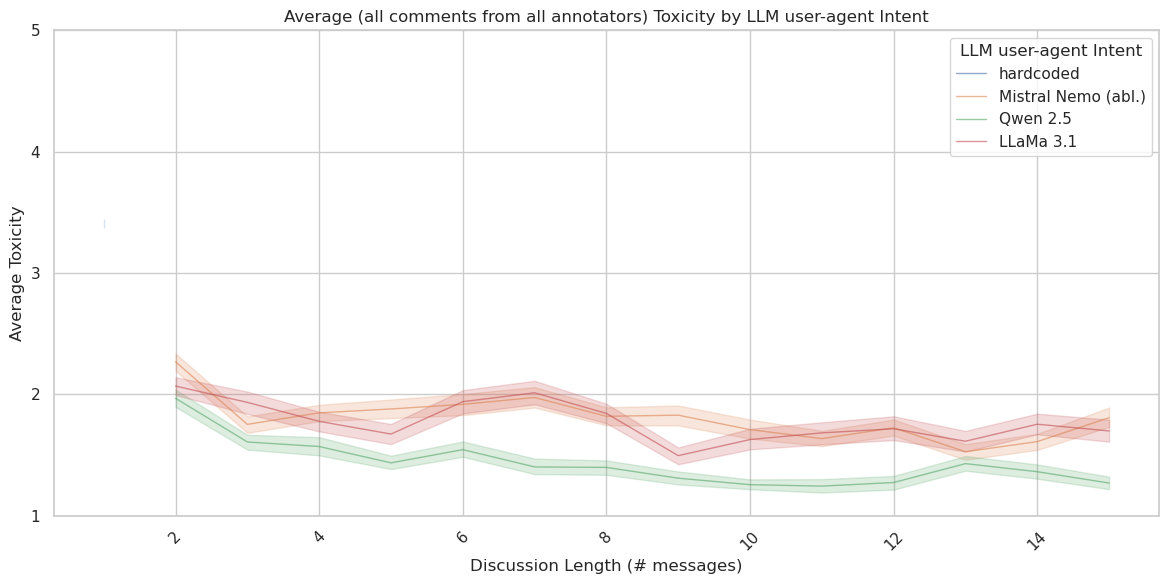

In [25]:
plot_timeseries(df, y_col="toxicity", hue_col="model", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)
plt.show()

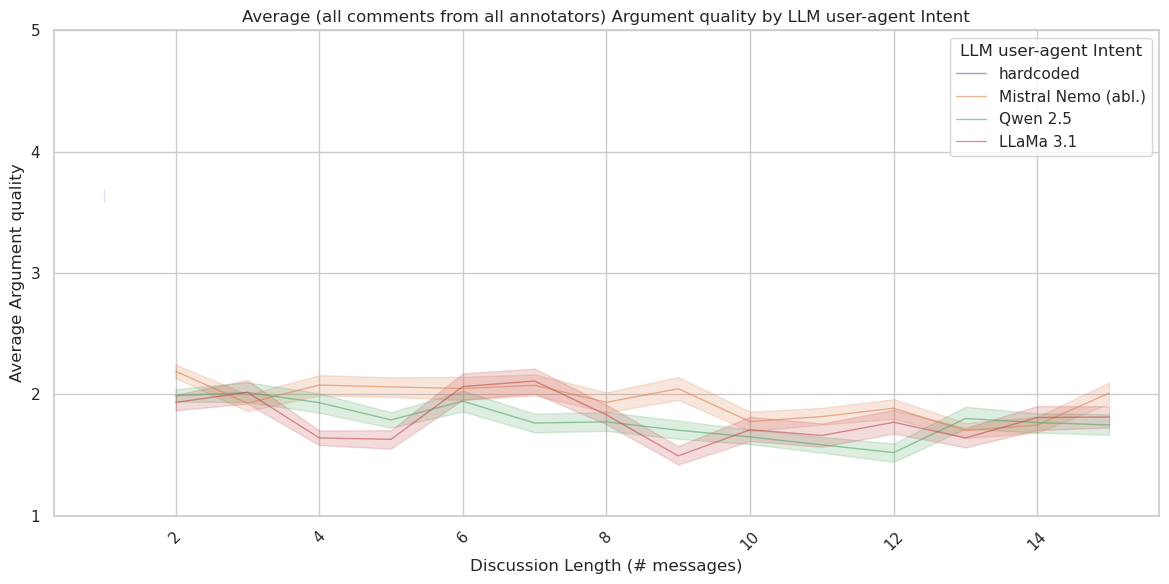

In [26]:
plot_timeseries(df, y_col="Argument Quality", hue_col="model", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)
plt.show()

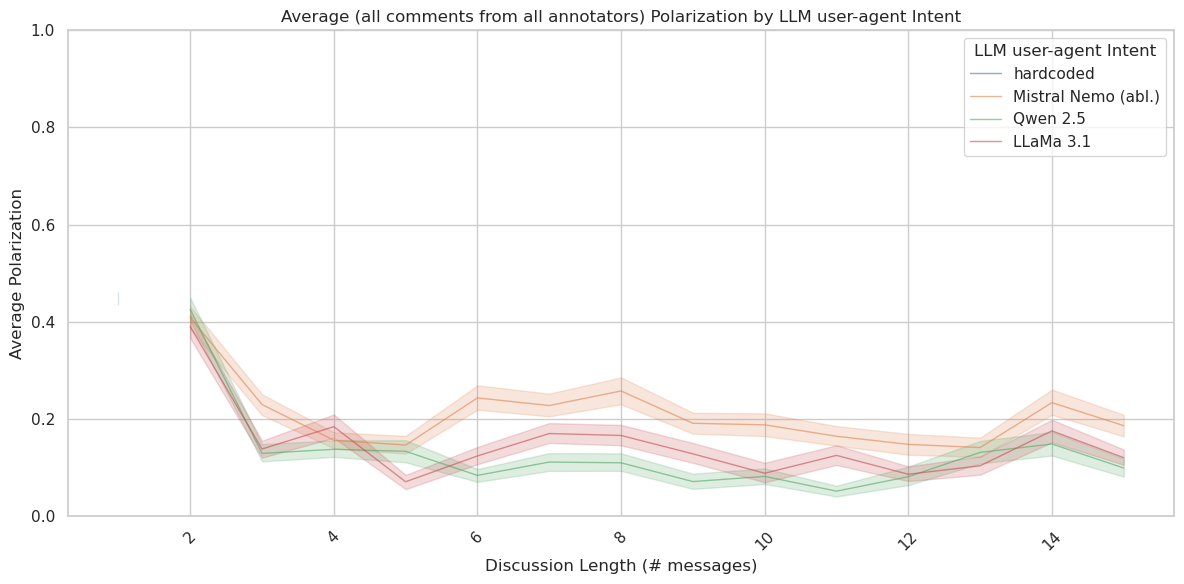

In [27]:
plot_timeseries(df, y_col="polarization", hue_col="model", hue_col_label="LLM user-agent Intent")
plt.yticks(POLARIZATION_TICKS)
plt.show()

## Investigating the impact of moderator interventions

Draw red lines when the moderator does not intervene

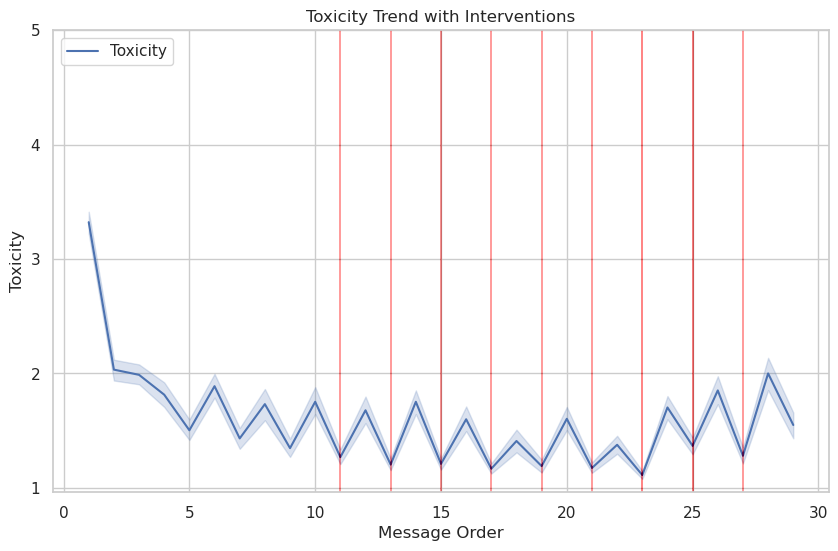

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter intervention data
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create the plot
plt.figure(figsize=(10, 6))

# Lineplot for toxicity over message order
sns.lineplot(data=intervention_df, x="message_order", y="toxicity", label="Toxicity")

# Add vertical dashed red lines where not_intervened is True
for msg_order in intervention_df.loc[intervention_df["not_intervened"], "message_order"]:
    plt.axvline(x=msg_order, color="red", linestyle="dashed", lw=0.02, alpha=0.2)

# Labels and title
plt.xlabel("Message Order")
plt.ylabel("Toxicity")
plt.title("Toxicity Trend with Interventions")
plt.yticks(TOXICITY_TICKS)

# Show plot
plt.show()


Repeat for each individual discussion

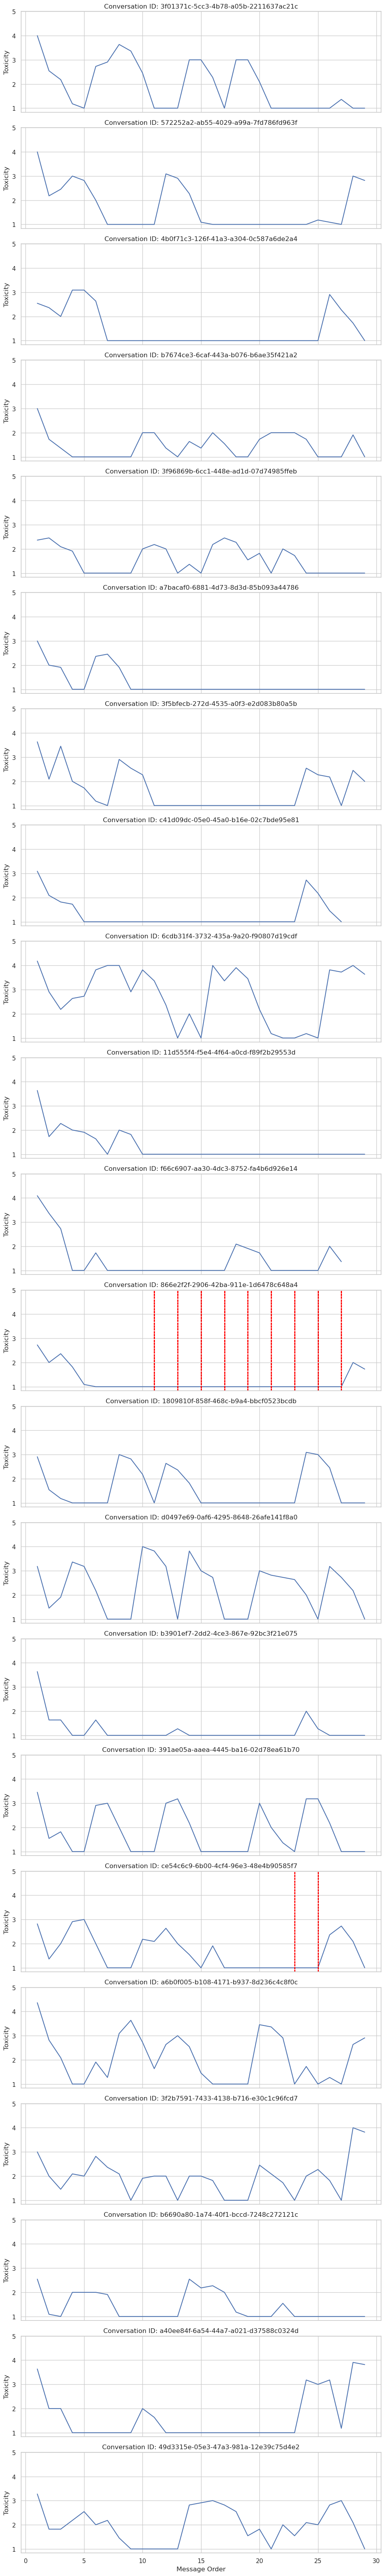

In [29]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create subplots (one for each conversation)
conv_ids = intervention_df.conv_id.unique()
fig, axes = plt.subplots(len(conv_ids), 1, figsize=(10, 3 * len(conv_ids)), sharex=True, sharey=True)

if len(conv_ids) == 1:
    axes = [axes]

for ax, conv_id in zip(axes, conv_ids):
    local_df = intervention_df[intervention_df.conv_id == conv_id]
    
    # Lineplot for toxicity trend
    sns.lineplot(data=local_df, x="message_order", y="toxicity", ax=ax, errorbar=None)
    
    # Add vertical dashed red lines for not_intervened points
    for msg_order in local_df.loc[local_df["not_intervened"], "message_order"]:
        ax.axvline(x=msg_order, color="red", linestyle="dashed", lw=1, alpha=0.5)
    
    ax.set_title(f"Conversation ID: {conv_id}")
    ax.set_ylabel("Toxicity")
    ax.set_yticks(TOXICITY_TICKS)


plt.xlabel("Message Order")
plt.tight_layout()
plt.show()


Non-interventions are an anomaly seen in mostly one discussion.

## User Analysis: Underlying Model

### Comment length

In [30]:
len_df = full_df.copy()
len_df["comment_length"] = len_df.message.apply(lambda x: len(x.split()))
len_df = len_df.loc[len_df.model != "hardcoded", ["message_id", "comment_length", "model"]]
len_df = len_df.drop_duplicates(subset=["message_id"])

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/comment_length.png


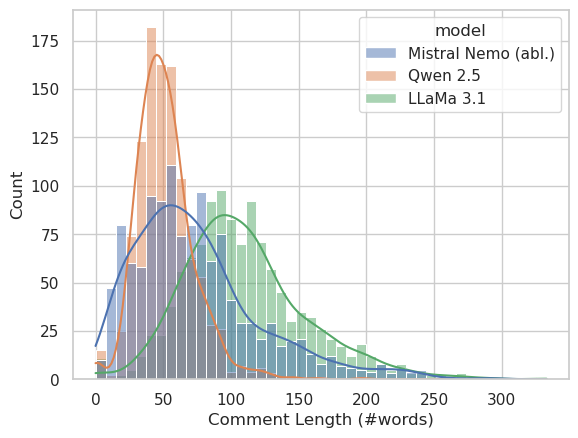

In [31]:
sns.histplot(len_df, x="comment_length", hue="model", kde=True)
plt.xlabel("Comment Length (#words)")
save_plot(GRAPH_OUTPUT_DIR / "comment_length.png")
plt.show()

In [32]:
message_df = full_df.copy()
message_df = message_df.drop_duplicates(subset=["conv_id", "message_id"])
# @ tokens crash bleu scorer
message_df.message = message_df.message.apply(lambda msg: " ".join(word for word in msg.split() if not word.startswith("@")))

similarity_df = (
    message_df.groupby(["conv_id", "model"])['message']
    .apply(lambda messages: messages.tolist())
    .reset_index()
) 
similarity_df.columns = ["conv_id", "model", "messages"]
similarity_df = similarity_df[similarity_df.model != "hardcoded"] 

In [33]:
similarity_df["rougel_similarity"] = similarity_df.messages.progress_apply(tasks.stats.pairwise_rougel_similarity)

 37%|███▋      | 52/140 [00:10<00:17,  4.95it/s]


KeyboardInterrupt: 

In [ ]:
sns.histplot(similarity_df, x="rougel_similarity", hue="model", kde=True)
plt.xlabel("Average pairwise F1 ROUGE-L")
plt.title("Intra-discussion comment variance")
save_plot(GRAPH_OUTPUT_DIR / "variance.png")
plt.show()